## Matheus Cerqueira e Pedro Hugo - ENGC67 - PROJETO 2

Expecificações de Projeto:

- Projetar, a partir de um filtro passa-baixas Butterworth de sexta ordem, um filtro discreto passa-baixas com frequência de corte (-3dB) ωc = 2π/3, usando o método de transformação bilinear. Fazer a implementação sob forma direta e sob forma em cascata;
- Representar os coeficientes em ponto flutuante (ex.: 0, 00423578 = 0, 423578 × 10⁻²) e diminuir progressivamente o número de casas decimais após a vírgula nas formas direta e em cascata para verificar a sensibilidade à quantização de parâmetros.
- Traçar a curva do módulo da resposta em frequência em dB para os casos de precisão infinita e precisão finita;
- Em seguida, para a representação em forma direta, refazer os filtros com as 3 transformações em frequência a seguir (Z⁻¹ = −z¹; Z⁻¹ = z⁻² e Z⁻¹ = −z⁻²) e traçar a curva do módulo em dB da resposta em frequência resultante;
- Usar os filtros para processar um sinal de áudio, ouvir os resultados e os avaliar perceptualmente.
- Avaliar, também, o espectro em função do tempo, do sinal de entrada e de saída utilizando um espectrograma.

# 1. Projetando o filtro passa-baixas via transformação bilinear

## 1.1. Definindo parâmetros do filtro *Butterworth* analógico

In [116]:
import numpy as np

ordem = 6  # Ordem do filtro
cutoff_freq = (2/3) * np.pi  # Frequência de corte em radianos / segundo

fs = 44100 # Frequência de amostragem para sinal de audio
wn = fs*cutoff_freq
fc = wn/(2*np.pi)


## 1.2. Criando o filtro analógico *Butterworth* na forma direta

In [117]:
from scipy.signal import butter, iirfilter

# Projeto do filtro Butterworth analógico
butter_numerador, butter_denominador = iirfilter(ordem, wn,btype = 'lowpass',analog=True, ftype='butter')
print("Numerador:", butter_numerador)
print("Denominador:", butter_denominador)

Numerador: [6.20845044e+29]
Denominador: [1.00000000e+00 3.56862548e+05 6.36754392e+10 7.20302268e+15
 5.43208248e+20 2.59710665e+25 6.20845044e+29]


## 1.3. Criando o filtro passa-baixas discreto usando transformação bilinear (direta)

In [118]:
from scipy.signal import bilinear,dlti,freqz,freqs

# Frequência de amostragem
sampling_freq = 44100

# Transformação bilinear para filtro IIR na forma direta
filtz = dlti(*bilinear(butter_numerador, butter_denominador, fs=sampling_freq))

# Coeficientes do filtro em ponto flutuante
print("Forma direta (ponto flutuante):")
print("b:", filtz.num)
print("a:", filtz.den)

bz,az = freqz(filtz.num,filtz.den)
bs_bt,as_bt = freqs(butter_numerador,butter_denominador, worN =fs*bz)

Forma direta (ponto flutuante):
b: [0.03391037 0.20346223 0.50865558 0.67820744 0.50865558 0.20346223
 0.03391037]
a: [1.         0.17415911 0.78901525 0.08259211 0.11713691 0.00554934
 0.0018111 ]


### 1.3.1. Gráfico do filtro Butterworth (direta)

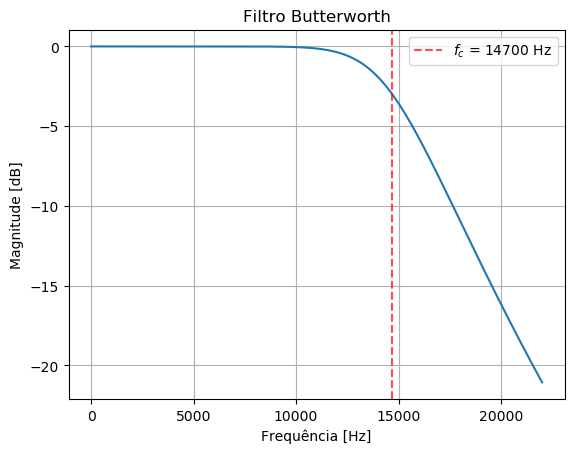

In [119]:
from scipy import signal
import matplotlib.pyplot as plt

plt.plot(bz*fs/(2*np.pi), 20*np.log10(np.abs(as_bt)))
plt.axvline(x=fc, color='red', ls='--', label='$f_c$ = {} Hz'.format(round(fc)), alpha=0.7)
ax = plt.axis()
plt.legend()
plt.title('Filtro Butterworth')
plt.xlabel('Frequência [Hz]')
plt.ylabel('Magnitude [dB]')
plt.grid()
plt.show()

### 1.3.2. Gráfico do filtro passa-baixas discreto (direta)

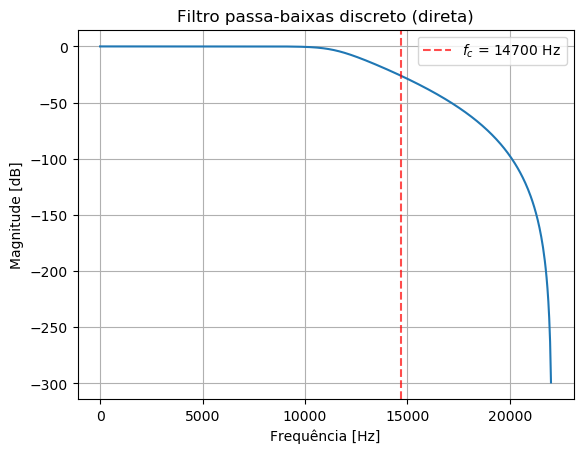

In [120]:
from scipy import signal
import matplotlib.pyplot as plt

plt.plot(bz*fs/(2*np.pi), 20*np.log10(np.abs(az)))
plt.axvline(x=fc, color='red', ls='--', label='$f_c$ = {} Hz'.format(round(fc)), alpha=0.7)
plt.legend()
plt.title('Filtro passa-baixas discreto (direta)')
plt.xlabel('Frequência [Hz]')
plt.ylabel('Magnitude [dB]')
plt.grid()
plt.show()

## 1.4. Criando o filtro analógico *Butterworth* na forma cascata

In [121]:
# Projeto do filtro Butterworth analógico

butter_zpk = iirfilter(ordem, wn,btype = 'lowpass',analog=True, ftype='butter',output='zpk')
filtro_zpk = signal.lti(*butter_zpk)

## 1.5. Criação do filtro passa-baixas discreto usando transformação bilinear (cascata)

In [122]:
from scipy.signal import butter, sosfilt, sos2tf, bilinear, zpk2tf
import numpy as np

# Frequência de amostragem normalizada
sampling_freq = 44100

filtz_cascata = signal.dlti(*signal.bilinear_zpk(filtro_zpk.zeros, filtro_zpk.poles, filtro_zpk.gain, fs=sampling_freq))
sos = signal.zpk2sos(filtz_cascata.zeros, filtz_cascata.poles,filtz_cascata.gain)

### 1.5.1. Gráfico do filtro passa-baixas discreto (cascata) 

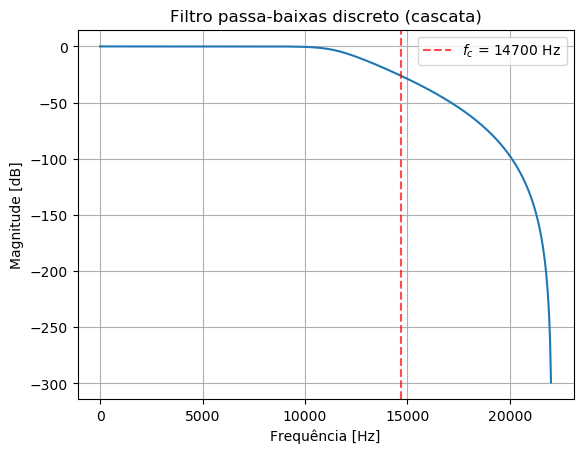

In [123]:
from scipy import signal
import matplotlib.pyplot as plt

bz_cascata,az_cascata = signal.sosfreqz(sos)

plt.plot(bz_cascata*fs/(2*np.pi), 20*np.log10(np.abs(az_cascata)))
plt.axvline(x=fc, color='red', ls='--', label='$f_c$ = {} Hz'.format(round(fc)), alpha=0.7)
plt.legend()
plt.title('Filtro passa-baixas discreto (cascata)')
plt.xlabel('Frequência [Hz]')
plt.ylabel('Magnitude [dB]')
plt.grid()
plt.show()

# 2. Mudança da precisão

## 2.1. Mudança de precisão da quantização da forma direta

In [124]:
import numpy as np

# Quantização dos coeficientes
decimal_points = [6, 4, 2]  # Número de casas decimais após a vírgula para quantização
quantized_b_direto = []
quantized_a_direto = []

for dp in decimal_points:
  quantized_b_direto.append(np.round(filtz.num, dp))
  quantized_a_direto.append(np.round(filtz.den, dp))

for i in range(0, len(quantized_b_direto)):
  print("\nForma direta (", decimal_points[i], " casas decimais):")
  print("b:", quantized_b_direto[i])
  print("a:", quantized_a_direto[i])

#print(np.round())


Forma direta ( 6  casas decimais):
b: [0.03391  0.203462 0.508656 0.678207 0.508656 0.203462 0.03391 ]
a: [1.       0.174159 0.789015 0.082592 0.117137 0.005549 0.001811]

Forma direta ( 4  casas decimais):
b: [0.0339 0.2035 0.5087 0.6782 0.5087 0.2035 0.0339]
a: [1.     0.1742 0.789  0.0826 0.1171 0.0055 0.0018]

Forma direta ( 2  casas decimais):
b: [0.03 0.2  0.51 0.68 0.51 0.2  0.03]
a: [1.   0.17 0.79 0.08 0.12 0.01 0.  ]


### 2.1.1. Gráficos da mudança de precisão da quantização da forma direta

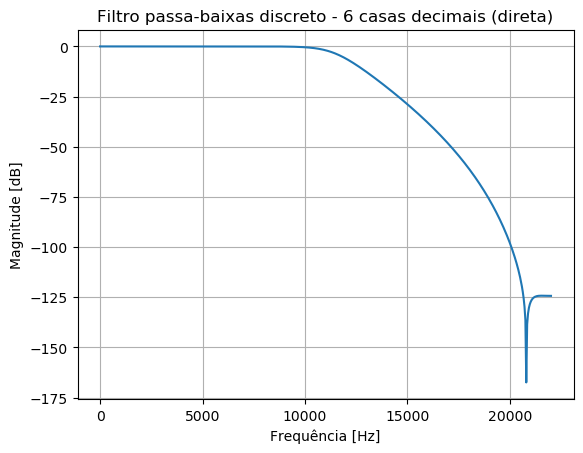

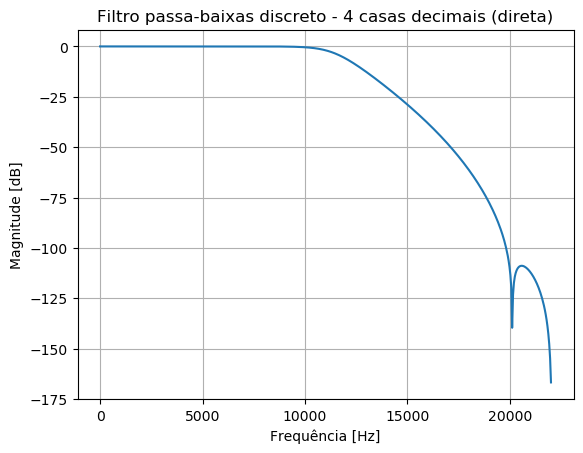

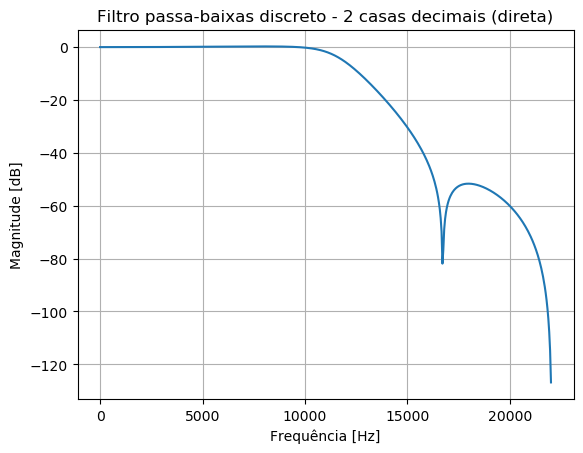

In [125]:
from scipy import signal
import matplotlib.pyplot as plt

for filtro in range(0,len(decimal_points)):
    bz,az = signal.freqz(quantized_b_direto[filtro],quantized_a_direto[filtro])
    plt.plot(bz*fs/(2*np.pi), 20*np.log10(np.abs(az)))
    plt.title('Filtro passa-baixas discreto - '+str(decimal_points[filtro])+' casas decimais (direta)')
    plt.xlabel('Frequência [Hz]')
    plt.ylabel('Magnitude [dB]')
    plt.grid()
    plt.show()

## 2.2. Mudança na precisão da quantização da forma cascata

In [126]:
# Quantização dos coeficientes
decimal_points = [6, 4, 2]  # Número de casas decimais após a vírgula para quantização
quantized_sos_cascata = []

for dp in decimal_points:
  quantized_sos_cascata.append(np.round(sos, dp))

for i in range(0, len(quantized_b_direto)):
  print("\nForma cascata (", decimal_points[i], " casas decimais):")
  print("sos:", quantized_sos_cascata[i])


Forma cascata ( 6  casas decimais):
sos: [[0.03391  0.067821 0.03391  1.       0.046908 0.017864]
 [1.       2.       1.       1.       0.054016 0.172089]
 [1.       2.       1.       1.       0.073235 0.589138]]

Forma cascata ( 4  casas decimais):
sos: [[0.0339 0.0678 0.0339 1.     0.0469 0.0179]
 [1.     2.     1.     1.     0.054  0.1721]
 [1.     2.     1.     1.     0.0732 0.5891]]

Forma cascata ( 2  casas decimais):
sos: [[0.03 0.07 0.03 1.   0.05 0.02]
 [1.   2.   1.   1.   0.05 0.17]
 [1.   2.   1.   1.   0.07 0.59]]


### 2.2.1 Gráficos da mudança de precisão da quantização da forma cascata

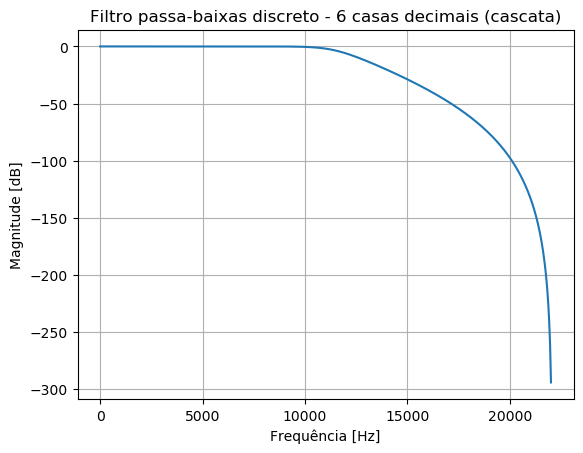

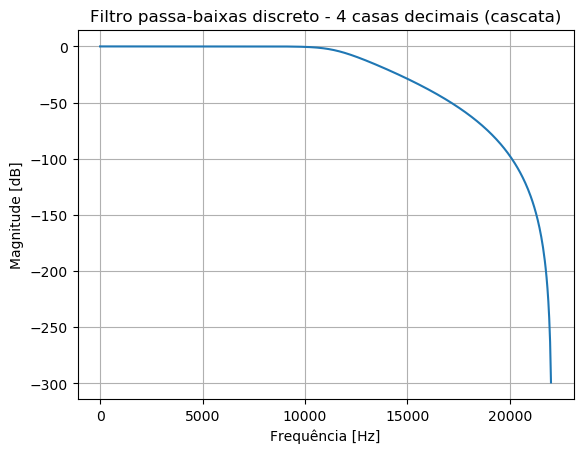

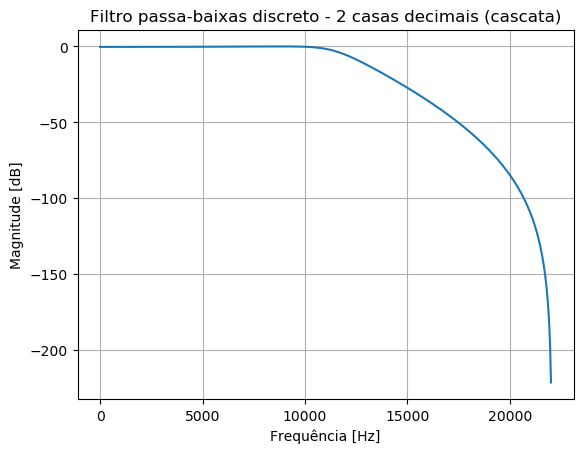

In [127]:
for filtro in range(0,len(decimal_points)):
  bz_cascata,az_cascata = signal.sosfreqz(quantized_sos_cascata[filtro])
  plt.plot(bz_cascata*fs/(2*np.pi), 20*np.log10(np.abs(az_cascata)))
  print()
  plt.title('Filtro passa-baixas discreto - '+str(decimal_points[filtro])+' casas decimais (cascata)')
  plt.xlabel('Frequência [Hz]')
  plt.ylabel('Magnitude [dB]')
  plt.grid()
  plt.show()

# 3. Transformação 

## 3.1 Passa-alta: $Z^{-1} = -z^{-1}$

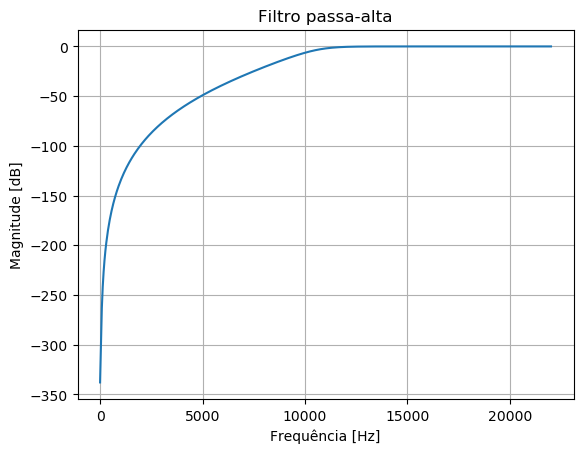

In [128]:

b_hp = filtz.num.copy()
a_hp = filtz.den.copy()

# slicing
b_hp[::2] *= -1
a_hp[::2] *= -1

bz_hp,az_hp = signal.freqz(b_hp,a_hp)

plt.plot(bz_hp*fs/(2*np.pi), 20*np.log10(np.abs(az_hp)))
plt.title('Filtro passa-alta')
plt.xlabel('Frequência [Hz]')
plt.ylabel('Magnitude [dB]')
plt.grid()
plt.show()

## 3.2 Rejeita faixa: $Z^{-1} = z^{-2}$

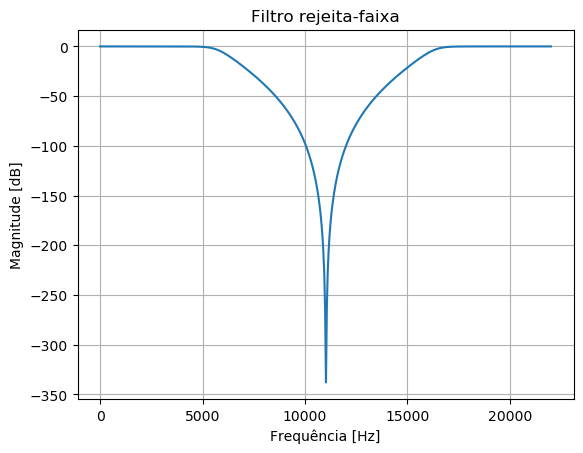

In [129]:
b_rf = filtz.num.copy()
a_rf = filtz.den.copy()

b_rf = np.zeros(len(filtz.num)*2 - 1, dtype=filtz.num.dtype)
b_rf[::2] = filtz.num
a_rf = np.zeros(len(filtz.den)*2 - 1, dtype=filtz.den.dtype)
a_rf[::2] = filtz.den

bz_bs,az_bs = signal.freqz(b_rf,a_rf)

plt.plot(bz_bs*fs/(2*np.pi), 20*np.log10(np.abs(az_bs)))
plt.title('Filtro rejeita-faixa')
plt.xlabel('Frequência [Hz]')
plt.ylabel('Magnitude [dB]')
plt.grid()
plt.show()

## 3.3 Passa-faixa $Z^{-1} = -z^{-2}$

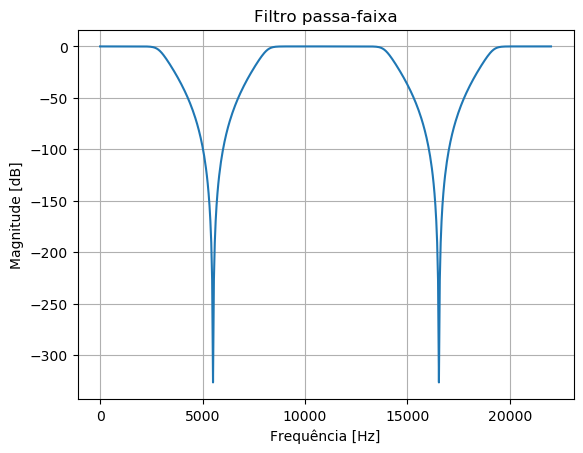

In [130]:
b_rf[::2] *= -1
a_rf[::2] *= -1

b_pf = np.zeros(len(b_rf)*2 - 1, dtype=b_rf.dtype)
b_pf[::2] = b_rf
a_pf = np.zeros(len(a_rf)*2 - 1, dtype=a_rf.dtype)
a_pf[::2] = a_rf

bz_bp,az_bp = signal.freqz(b_pf,a_pf)

plt.plot(bz_bp*fs/(2*np.pi), 20*np.log10(np.abs(az_bp)))
plt.title('Filtro passa-faixa')
plt.xlabel('Frequência [Hz]')
plt.ylabel('Magnitude [dB]')
plt.grid()
plt.show()

# 4. Música Vivaldi

## 4.1. Importando a música

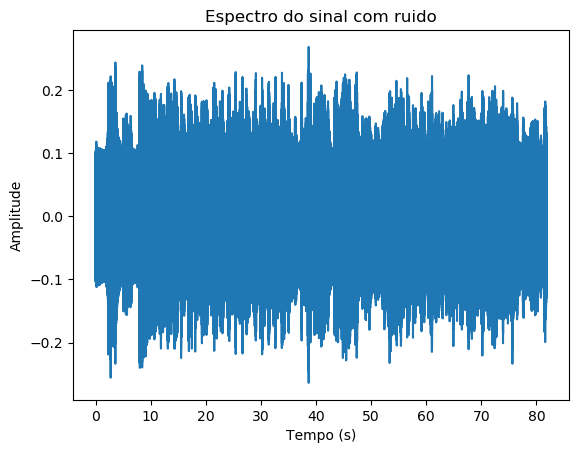

<Figure size 640x480 with 0 Axes>

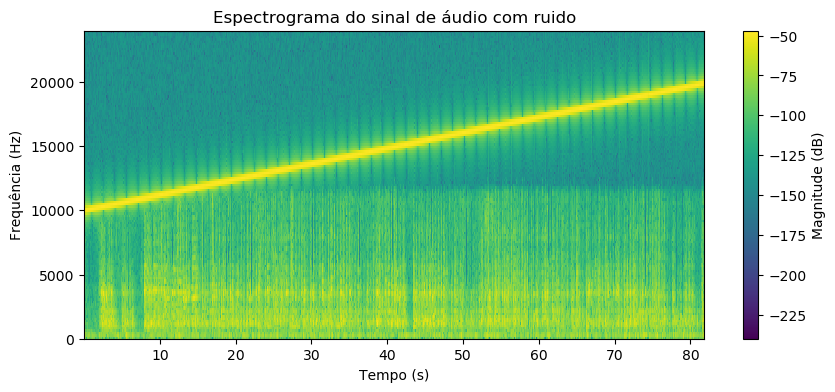

In [131]:
import matplotlib.pyplot as plt
import soundfile as sf
from  scipy import signal as sgn
from  scipy.io import wavfile as wav
import numpy as np

signal,fs = sf.read('Vivaldi_Ruido.wav')

ps = 1/fs
t = np.arange(0,len(signal)*ps,ps)

# Convertendo para mono

signal = np.mean(signal, axis=1)

# Espectro

plt.figure(1)
plt.title("Espectro do sinal com ruido")
plt.xlabel("Tempo (s)")
plt.ylabel("Amplitude")
plt.plot(t,signal)
plt.show()

# Espectograma

plt.figure(2)
plt.figure(figsize=(10, 4), dpi=100)
plt.specgram(signal, Fs=fs, sides='onesided')
plt.colorbar(label='Magnitude (dB)')
plt.xlabel('Tempo (s)')
plt.ylabel('Frequência (Hz)')
plt.title('Espectrograma do sinal de áudio com ruido')
plt.show()


## 4.2. Filtrando a música

### 4.2.1. Filtrando pelo passa-baixa (direto)

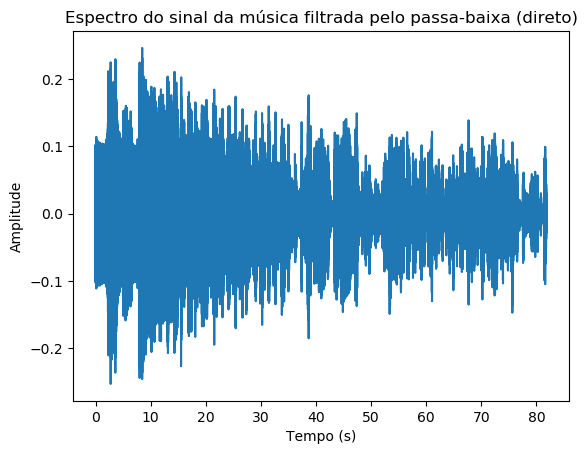

<Figure size 640x480 with 0 Axes>

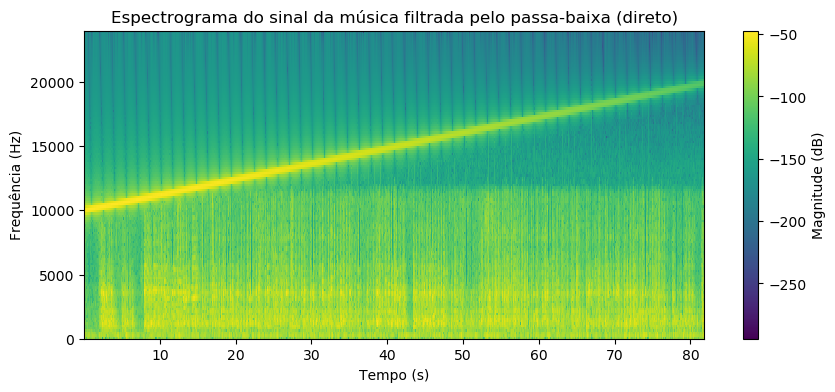

In [132]:
musica_filtrada = sgn.lfilter(filtz.num,filtz.den,signal)
musica_filtrada = np.real(musica_filtrada)
wav.write('musica_filtrada_pbd.wav',fs,musica_filtrada)

# Plotando a música filtrada

plt.figure(3)
plt.title("Espectro do sinal da música filtrada pelo passa-baixa (direto)")
plt.xlabel("Tempo (s)")
plt.ylabel("Amplitude")
plt.plot(t,musica_filtrada)
plt.show()

# Plotar o espectrograma
plt.figure(4)
plt.figure(figsize=(10, 4), dpi=100)
plt.specgram(musica_filtrada, Fs=fs, sides='onesided')
plt.colorbar(label='Magnitude (dB)')
plt.xlabel('Tempo (s)')
plt.ylabel('Frequência (Hz)')
plt.title('Espectrograma do sinal da música filtrada pelo passa-baixa (direto)')
plt.show()

### 4.2.2. Filtrando pelo passa-baixa (6 casas decimais)

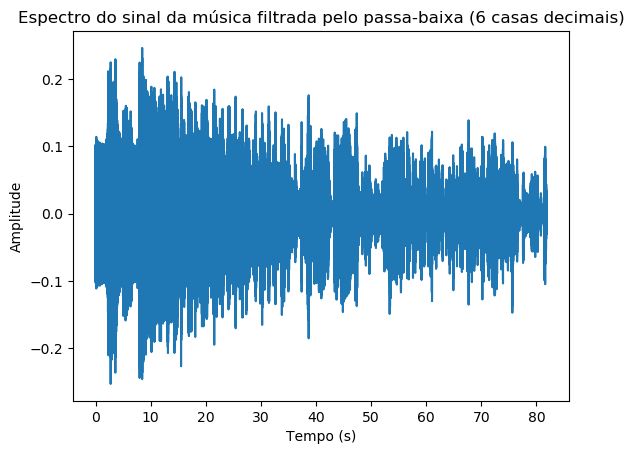

<Figure size 640x480 with 0 Axes>

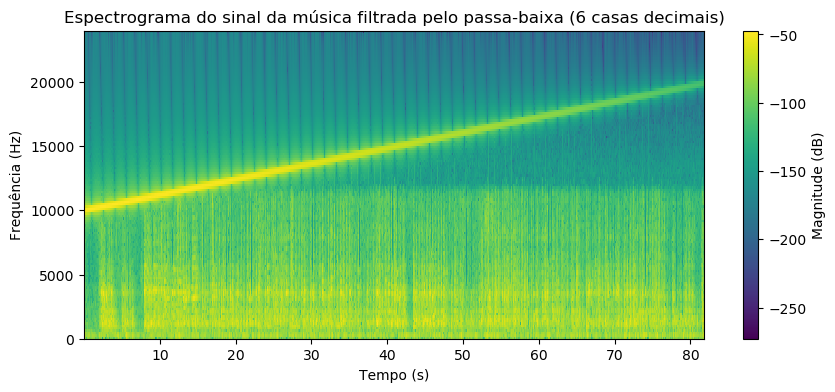

In [133]:
musica_filtrada = sgn.lfilter(quantized_b_direto[0],quantized_a_direto[0],signal)
musica_filtrada = np.real(musica_filtrada)
wav.write('musica_filtrada_pb6.wav',fs,musica_filtrada)

# Plotando a música filtrada

plt.figure(5)
plt.title("Espectro do sinal da música filtrada pelo passa-baixa (6 casas decimais)")
plt.xlabel("Tempo (s)")
plt.ylabel("Amplitude")
plt.plot(t,musica_filtrada)
plt.show()

# Plotar o espectrograma
plt.figure(6)
plt.figure(figsize=(10, 4), dpi=100)
plt.specgram(musica_filtrada, Fs=fs, sides='onesided')
plt.colorbar(label='Magnitude (dB)')
plt.xlabel('Tempo (s)')
plt.ylabel('Frequência (Hz)')
plt.title('Espectrograma do sinal da música filtrada pelo passa-baixa (6 casas decimais)')
plt.show()

### 4.2.3. Filtrando pelo passa-baixa (4 casas decimais)

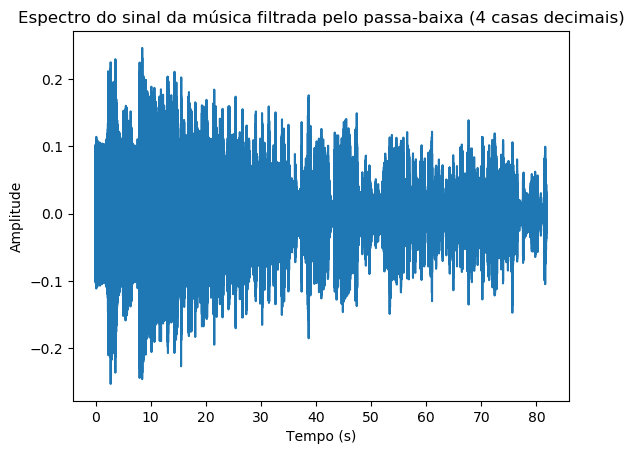

<Figure size 640x480 with 0 Axes>

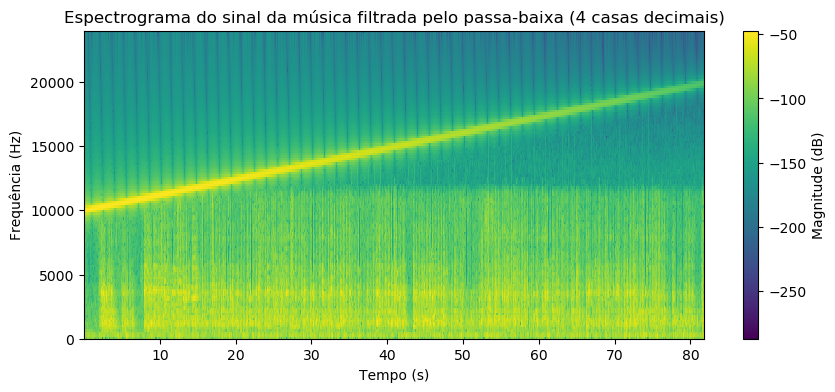

In [134]:
musica_filtrada = sgn.lfilter(quantized_b_direto[1],quantized_a_direto[1],signal)
musica_filtrada = np.real(musica_filtrada)
wav.write('musica_filtrada_pb4.wav',fs,musica_filtrada)

# Plotando a música filtrada

plt.figure(5)
plt.title("Espectro do sinal da música filtrada pelo passa-baixa (4 casas decimais)")
plt.xlabel("Tempo (s)")
plt.ylabel("Amplitude")
plt.plot(t,musica_filtrada)
plt.show()

# Plotar o espectrograma
plt.figure(6)
plt.figure(figsize=(10, 4), dpi=100)
plt.specgram(musica_filtrada, Fs=fs, sides='onesided')
plt.colorbar(label='Magnitude (dB)')
plt.xlabel('Tempo (s)')
plt.ylabel('Frequência (Hz)')
plt.title('Espectrograma do sinal da música filtrada pelo passa-baixa (4 casas decimais)')
plt.show()

### 4.2.4. Filtrando pelo passa-baixa (2 casas decimais)

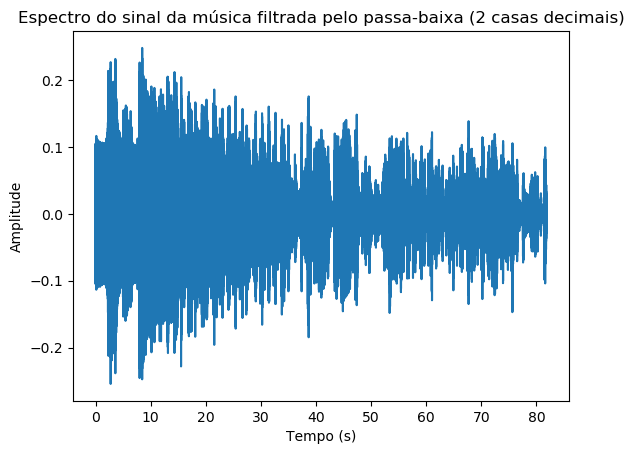

<Figure size 640x480 with 0 Axes>

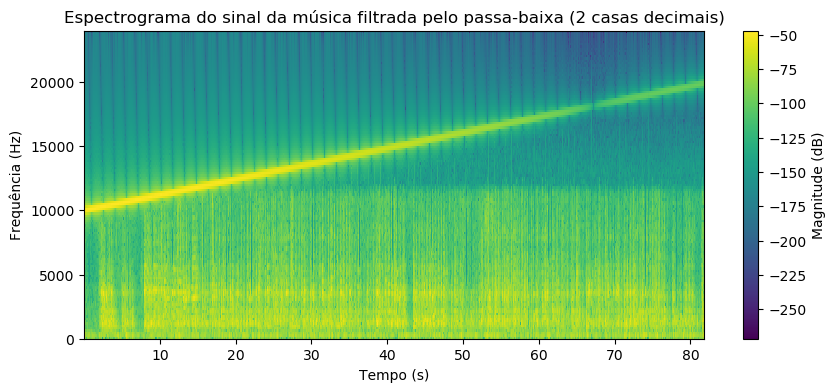

In [135]:
musica_filtrada = sgn.lfilter(quantized_b_direto[2],quantized_a_direto[2],signal)
musica_filtrada = np.real(musica_filtrada)
wav.write('musica_filtrada_pb2.wav',fs,musica_filtrada)

# Plotando a música filtrada

plt.figure(6)
plt.title("Espectro do sinal da música filtrada pelo passa-baixa (2 casas decimais)")
plt.xlabel("Tempo (s)")
plt.ylabel("Amplitude")
plt.plot(t,musica_filtrada)
plt.show()

# Plotar o espectrograma

plt.figure(7)
plt.figure(figsize=(10, 4), dpi=100)
plt.specgram(musica_filtrada, Fs=fs, sides='onesided')
plt.colorbar(label='Magnitude (dB)')
plt.xlabel('Tempo (s)')
plt.ylabel('Frequência (Hz)')
plt.title('Espectrograma do sinal da música filtrada pelo passa-baixa (2 casas decimais)')
plt.show()

### 4.2.5. Filtrando pelo passa-baixa (cascata)

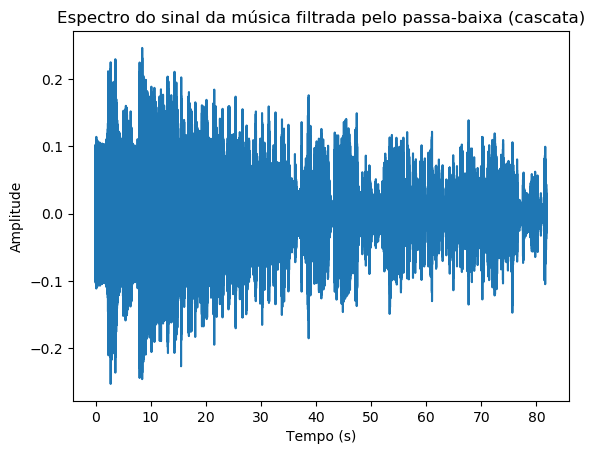

<Figure size 640x480 with 0 Axes>

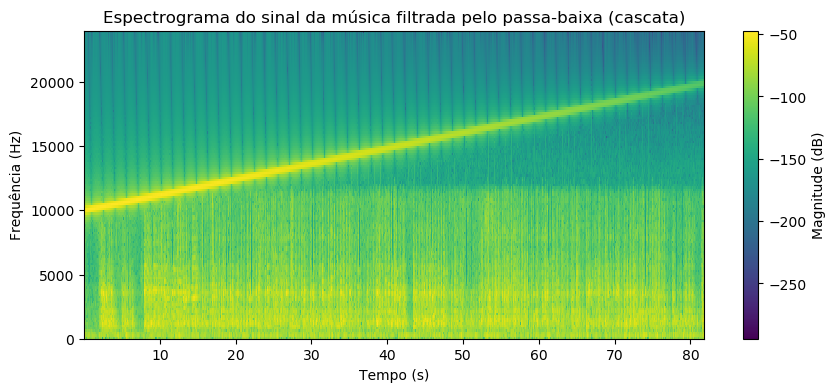

In [136]:
musica_filtrada = sgn.sosfilt(sos,signal)
musica_filtrada = np.real(musica_filtrada)
wav.write('musica_filtrada_pbc.wav',fs,musica_filtrada)

# Plotando a música filtrada

plt.figure(8)
plt.title("Espectro do sinal da música filtrada pelo passa-baixa (cascata)")
plt.xlabel("Tempo (s)")
plt.ylabel("Amplitude")
plt.plot(t,musica_filtrada)
plt.show()

# Plotar o espectrograma

plt.figure(9)
plt.figure(figsize=(10, 4), dpi=100)
plt.specgram(musica_filtrada, Fs=fs, sides='onesided')
plt.colorbar(label='Magnitude (dB)')
plt.xlabel('Tempo (s)')
plt.ylabel('Frequência (Hz)')
plt.title('Espectrograma do sinal da música filtrada pelo passa-baixa (cascata)')
plt.show()

### 4.2.6. Filtrando pelo passa-baixa (cascata - 6 casas decimais)

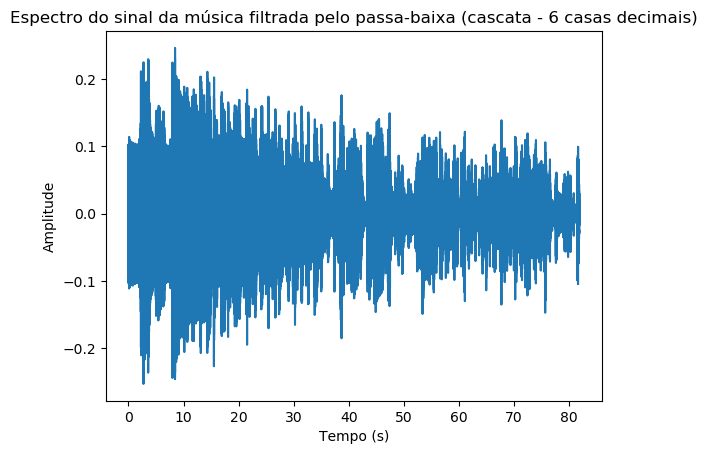

<Figure size 640x480 with 0 Axes>

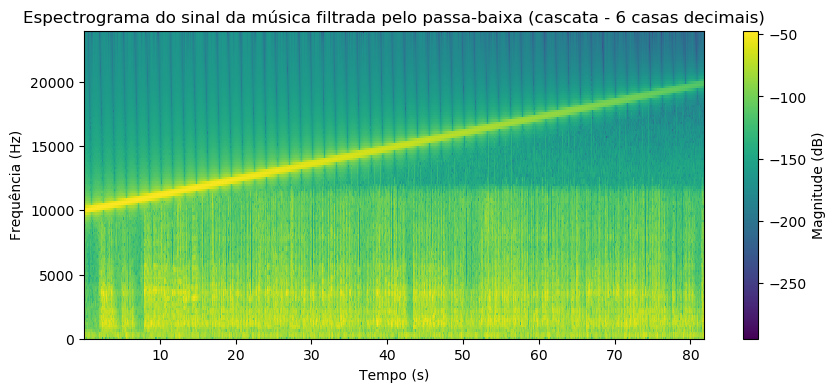

In [137]:
musica_filtrada = sgn.sosfilt(quantized_sos_cascata[0],signal)
musica_filtrada = np.real(musica_filtrada)
wav.write('musica_filtrada_pbc6.wav',fs,musica_filtrada)

# Plotando a música filtrada

plt.figure(10)
plt.title("Espectro do sinal da música filtrada pelo passa-baixa (cascata - 6 casas decimais)")
plt.xlabel("Tempo (s)")
plt.ylabel("Amplitude")
plt.plot(t,musica_filtrada)
plt.show()

# Plotar o espectrograma

plt.figure(11)
plt.figure(figsize=(10, 4), dpi=100)
plt.specgram(musica_filtrada, Fs=fs, sides='onesided')
plt.colorbar(label='Magnitude (dB)')
plt.xlabel('Tempo (s)')
plt.ylabel('Frequência (Hz)')
plt.title('Espectrograma do sinal da música filtrada pelo passa-baixa (cascata - 6 casas decimais)')
plt.show()

### 4.2.7. Filtrando pelo passa-baixa (cascata - 4 casas decimais)

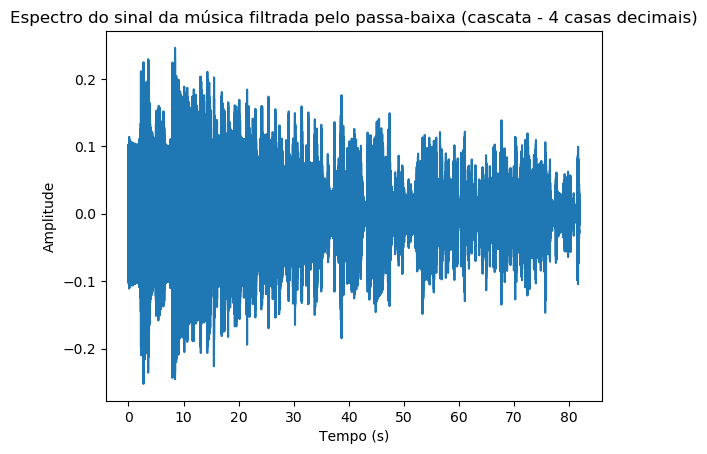

<Figure size 640x480 with 0 Axes>

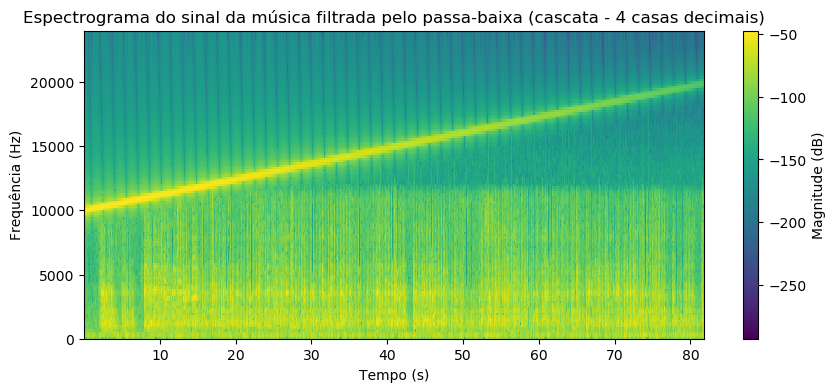

In [138]:
musica_filtrada = sgn.sosfilt(quantized_sos_cascata[1],signal)
musica_filtrada = np.real(musica_filtrada)
wav.write('musica_filtrada_pbc4.wav',fs,musica_filtrada)

# Plotando a música filtrada

plt.figure(12)
plt.title("Espectro do sinal da música filtrada pelo passa-baixa (cascata - 4 casas decimais)")
plt.xlabel("Tempo (s)")
plt.ylabel("Amplitude")
plt.plot(t,musica_filtrada)
plt.show()

# Plotar o espectrograma

plt.figure(13)
plt.figure(figsize=(10, 4), dpi=100)
plt.specgram(musica_filtrada, Fs=fs, sides='onesided')
plt.colorbar(label='Magnitude (dB)')
plt.xlabel('Tempo (s)')
plt.ylabel('Frequência (Hz)')
plt.title('Espectrograma do sinal da música filtrada pelo passa-baixa (cascata - 4 casas decimais)')
plt.show()

### 4.2.8. Filtrando pelo passa-baixa (cascata - 2 casas decimais)

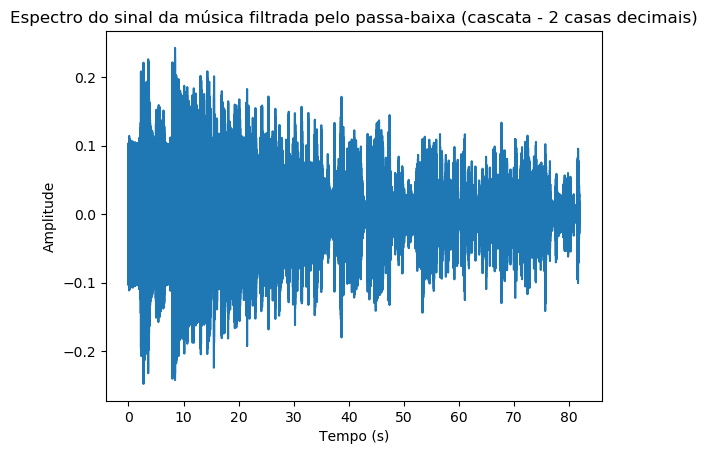

<Figure size 640x480 with 0 Axes>

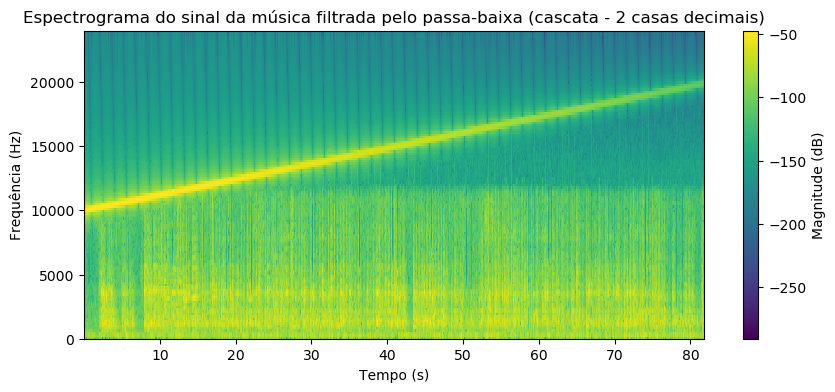

In [139]:
musica_filtrada = sgn.sosfilt(quantized_sos_cascata[2],signal)
musica_filtrada = np.real(musica_filtrada)
wav.write('musica_filtrada_pbc2.wav',fs,musica_filtrada)

# Plotando a música filtrada

plt.figure(14)
plt.title("Espectro do sinal da música filtrada pelo passa-baixa (cascata - 2 casas decimais)")
plt.xlabel("Tempo (s)")
plt.ylabel("Amplitude")
plt.plot(t,musica_filtrada)
plt.show()

# Plotar o espectrograma

plt.figure(15)
plt.figure(figsize=(10, 4), dpi=100)
plt.specgram(musica_filtrada, Fs=fs, sides='onesided')
plt.colorbar(label='Magnitude (dB)')
plt.xlabel('Tempo (s)')
plt.ylabel('Frequência (Hz)')
plt.title('Espectrograma do sinal da música filtrada pelo passa-baixa (cascata - 2 casas decimais)')
plt.show()

### 4.2.8. Filtrando pelo passa-alta

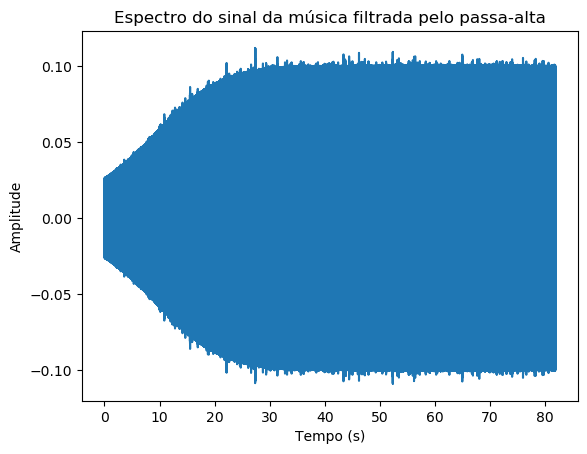

<Figure size 640x480 with 0 Axes>

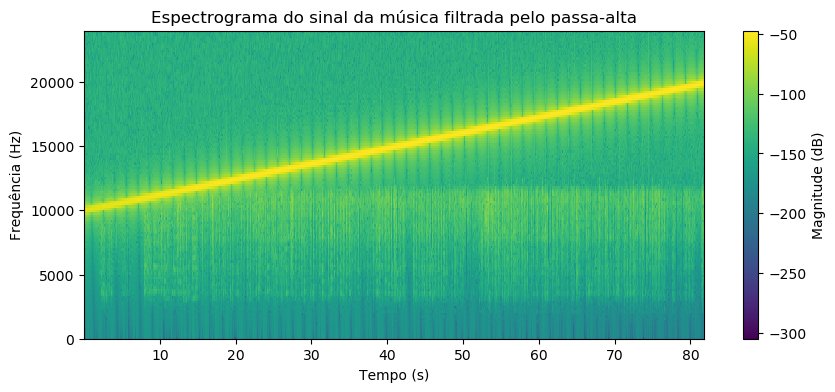

In [140]:
musica_filtrada = sgn.lfilter(b_hp,a_hp,signal)
musica_filtrada = np.real(musica_filtrada)
wav.write('musica_filtrada_pa.wav',fs,musica_filtrada)

# Plotando a música filtrada

plt.figure(16)
plt.title("Espectro do sinal da música filtrada pelo passa-alta")
plt.xlabel("Tempo (s)")
plt.ylabel("Amplitude")
plt.plot(t,musica_filtrada)
plt.show()

# Plotar o espectrograma

plt.figure(17)
plt.figure(figsize=(10, 4), dpi=100)
plt.specgram(musica_filtrada, Fs=fs, sides='onesided')
plt.colorbar(label='Magnitude (dB)')
plt.xlabel('Tempo (s)')
plt.ylabel('Frequência (Hz)')
plt.title('Espectrograma do sinal da música filtrada pelo passa-alta')
plt.show()

### 4.2.9. Filtrando pelo rejeita-faixa

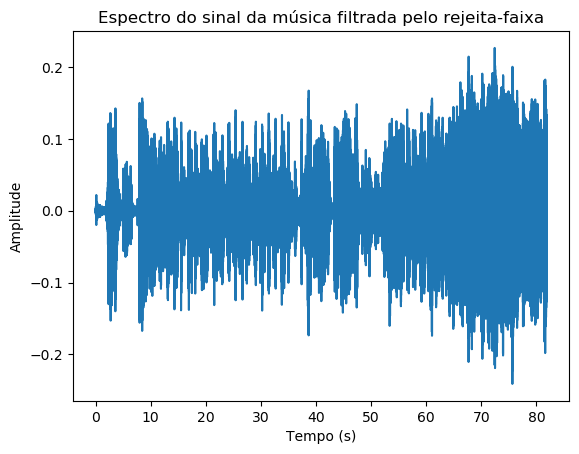

<Figure size 640x480 with 0 Axes>

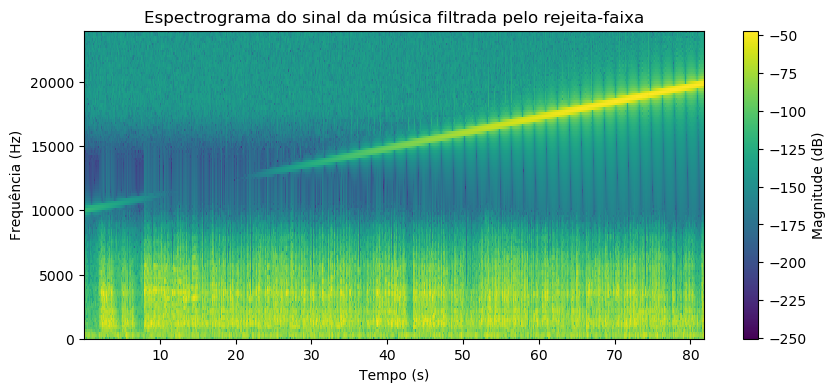

In [141]:
musica_filtrada = sgn.lfilter(b_rf,a_rf,signal)
musica_filtrada = np.real(musica_filtrada)
wav.write('musica_filtrada_rf.wav',fs,musica_filtrada)

# Plotando a música filtrada

plt.figure(18)
plt.title("Espectro do sinal da música filtrada pelo rejeita-faixa")
plt.xlabel("Tempo (s)")
plt.ylabel("Amplitude")
plt.plot(t,musica_filtrada)
plt.show()

# Plotar o espectrograma

plt.figure(19)
plt.figure(figsize=(10, 4), dpi=100)
plt.specgram(musica_filtrada, Fs=fs, sides='onesided')
plt.colorbar(label='Magnitude (dB)')
plt.xlabel('Tempo (s)')
plt.ylabel('Frequência (Hz)')
plt.title('Espectrograma do sinal da música filtrada pelo rejeita-faixa')
plt.show()

### 4.2.10. Filtrando pelo passa-faixa

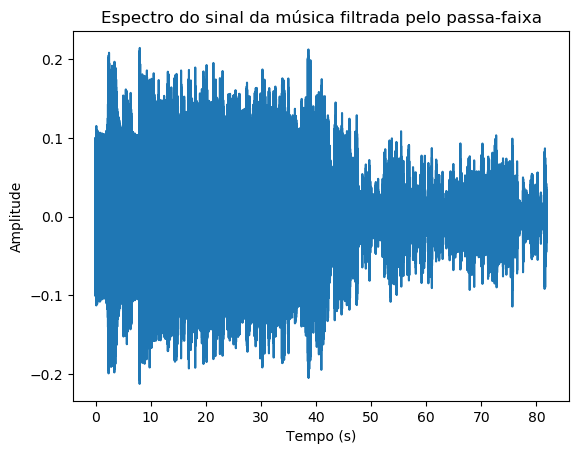

<Figure size 640x480 with 0 Axes>

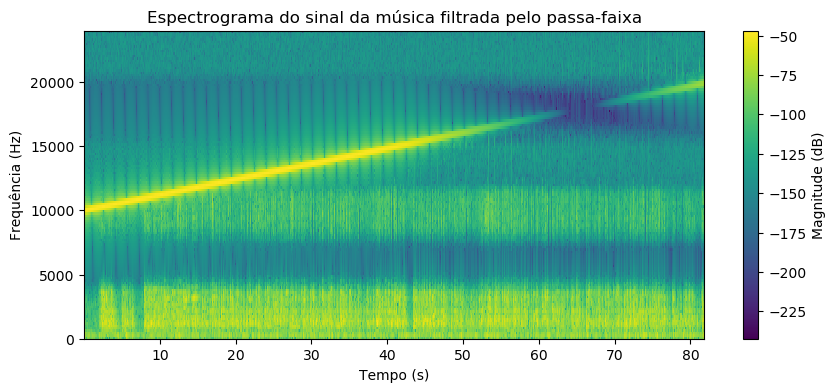

In [142]:
musica_filtrada = sgn.lfilter(b_pf,a_pf,signal)
musica_filtrada = np.real(musica_filtrada)
wav.write('musica_filtrada_pf.wav',fs,musica_filtrada)

# Plotando a música filtrada

plt.figure(20)
plt.title("Espectro do sinal da música filtrada pelo passa-faixa")
plt.xlabel("Tempo (s)")
plt.ylabel("Amplitude")
plt.plot(t,musica_filtrada)
plt.show()

# Plotar o espectrograma

plt.figure(21)
plt.figure(figsize=(10, 4), dpi=100)
plt.specgram(musica_filtrada, Fs=fs, sides='onesided')
plt.colorbar(label='Magnitude (dB)')
plt.xlabel('Tempo (s)')
plt.ylabel('Frequência (Hz)')
plt.title('Espectrograma do sinal da música filtrada pelo passa-faixa')
plt.show()